In [1]:
import time
import os
import ast

import IPython.display as ipd
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

import keras
from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Reshape

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.linear_model import LogisticRegression

from sklearn import linear_model


import matplotlib.pyplot as plt
import itertools

import utils
from utils import plot_confusion_matrix

Using TensorFlow backend.


### Constants

In [2]:
AUDIO_DIR = "..\\fma_small"
META_DIR = "..\\fma_metadata"
SUBSET = 'small'

### Load data

In [3]:
# Load metadata to memory
def load_meta_data(): 
    tracks_all   = utils.load(META_DIR + '\\tracks.csv')
    features_all = utils.load(META_DIR + '\\features.csv')
    echonest_all = utils.load(META_DIR + '\\echonest.csv')

    #genres = utils.load(META_DIR + 'genres.csv')

    np.testing.assert_array_equal(features_all.index, tracks_all.index)
    assert echonest_all.index.isin(tracks_all.index).all()
    
    
    return tracks_all, features_all, echonest_all

In [4]:
# Choose Subset
def choose_small_subset(tracks_all, features_all, echonest_all):
    subset = tracks_all.index[tracks_all['set', 'subset'] <= 'small']

    assert subset.isin(tracks_all.index).all()
    assert subset.isin(features_all.index).all()
    
    tracks = tracks_all.loc[subset]
    features = features_all.loc[subset]

    return tracks, features
    

In [5]:
tracks_all, features_all, echonest_all = load_meta_data()
tracks, features =  choose_small_subset(tracks_all, features_all, echonest_all)

D:\Dropbox\172B Big\Amadeus\fma_code\utils.py:214: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  'category', categories=SUBSETS, ordered=True)


In [6]:
tracks.shape, features.shape

((8000, 52), (8000, 518))

### Split Train Val Test

In [7]:
# Splitting into Train, Validation, Test
train_index = tracks.index[tracks['set', 'split'] == 'training']
val_index   = tracks.index[tracks['set', 'split'] == 'validation']
test_index  = tracks.index[tracks['set', 'split'] == 'test']


print('{} training examples'.format(len(train_index)))
print('{} validation examples'.format(len(val_index)))
print('{} testing examples'.format(len(test_index)))

6400 training examples
800 validation examples
800 testing examples


In [8]:
X = features.values
Y = tracks['track']['genre_top']

In [9]:
Xtrain = features.loc[train_index].values
Xval  = features.loc[val_index].values
Xtest  = features.loc[test_index].values

Ytrain = tracks.loc[train_index]['track']['genre_top'].values
Yval = tracks.loc[val_index]['track']['genre_top'].values
Ytest = tracks.loc[test_index]['track']['genre_top'].values

In [10]:
classes = list(set(Y))

### Logistic Regression Baseline (Works Well)

In [11]:
Xtrain = features.loc[train_index].values
Xval  = features.loc[val_index].values
Xtest  = features.loc[test_index].values

Ytrain = tracks.loc[train_index]['track']['genre_top']
Yval = tracks.loc[val_index]['track']['genre_top']
Ytest = tracks.loc[test_index]['track']['genre_top']

In [12]:
logreg = linear_model.LogisticRegression(verbose=2, max_iter=40)

In [13]:
logreg.fit(Xtrain, Ytrain)

[LibLinear]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:920: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=40, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=2, warm_start=False)

In [14]:
YtrainHat = logreg.predict(Xtrain)
np.mean(Ytrain == YtrainHat)

0.5909375

In [15]:
YtestHat = logreg.predict(Xtest)
np.mean(Ytest == YtestHat)

0.45124999999999998

In [16]:
YvalHat = logreg.predict(Xval)
np.mean(Yval == YvalHat)

0.53625

Confusion matrix, without normalization
[[55  7  2 15  4  3  7  7]
 [ 4 36 15  4 17 13  4  7]
 [ 0 20 14  0 12 26 18 10]
 [ 8  3  2 74  5  7  1  0]
 [ 3 14 25  3 45  1  5  4]
 [10  4 19  7  3 45 10  2]
 [24  3  8 12  4 11 30  8]
 [ 5  6  2  3  4  3 15 62]]


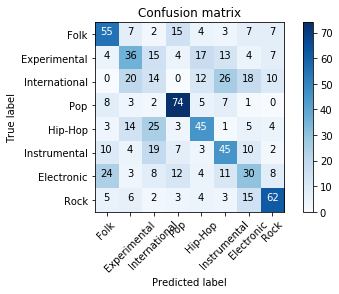

In [17]:
cnf_matrix = confusion_matrix(Ytest, YtestHat)
plot_confusion_matrix(cnf_matrix, classes)
plt.show()

### Deep Learning Model No Audio (broken model predicts all same genre)

In [ ]:
features = 518
genres = 8

In [ ]:
labelBinarizer = LabelBinarizer()
ohTrain = labelBinarizer.fit_transform(X=Ytrain)
ohVal  = labelBinarizer.fit_transform(X=Yval)

In [ ]:
def init_env_and_tfboard():
    from datetime import datetime
    now = datetime.now()

    keras.backend.clear_session()
    TFboard = keras.callbacks.TensorBoard(log_dir='./logs/FullyConnected_' + now.strftime("%Y%m%d-%H%M%S")  +'/', histogram_freq = 1)
    return TFBoard

In [ ]:
# model = keras.models.Sequential()
# model.add(Dense(units=600, input_shape=(features,)))
# model.add(Activation("relu"))
# #model.add(keras.layers.Dropout(0.5, noise_shape=None, seed=None))
# model.add(Dense(units=genres))
# model.add(Activation("sigmoid"))
from keras.models import Sequential

model = Sequential([
    Dense(32, input_shape=(features,)),
    Activation('relu'),
    Dense(genres),
    Activation('softmax'),
])    
    
optimizer = keras.optimizers.Adam()
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer, loss='mean_squared_error', metrics=['accuracy','categorical_accuracy'])

In [ ]:
params = {
        "callbacks": [TFboard],
        "validation_data": (Xval, ohVal)
}
history = model.fit(x = Xtrain, y = ohTrain, epochs=15, **params, verbose = 2)

In [ ]:
labelBinarizer.inverse_transform(model.predict(Xtrain))

In [ ]:
from collections import Counter
Counter(Ytrain)

### Deep Learning Model Using Audio

In [ ]:
labels_onehot = MultiLabelBinarizer().fit_transform(tracks['track', 'genre_top'])
labels_onehot = pd.DataFrame(labels_onehot, index=tracks.index)

In [ ]:
# Sanitation Test, Just making sure it works
utils.FfmpegLoader().load(utils.get_audio_path(AUDIO_DIR, 2))
SampleLoader = utils.build_sample_loader(AUDIO_DIR, labels_onehot, utils.FfmpegLoader())
SampleLoader(train, batch_size=2).__next__()[0].shape

In [ ]:
params = {
    
}

In [ ]:
def basic_fully_connected(loader, labels_onehot):
    model = keras.models.Sequential()
    model.add(Dense(units=1000, input_shape=loader.shape))
    model.add(Activation("relu"))
    model.add(Dense(units=100))
    model.add(Activation("relu"))
    model.add(Dense(units=labels_onehot.shape[1]))
    model.add(Activation("softmax"))
    
    optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True)
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [ ]:
loader = utils.FfmpegLoader(sampling_rate=2000)
SampleLoader = utils.build_sample_loader(AUDIO_DIR, labels_onehot, loader)
print('Dimensionality: {}'.format(loader.shape))

In [ ]:
keras.backend.clear_session()

model = basic_fully_connected(loader, labels_onehot)
model.fit_generator(SampleLoader(train, batch_size=64), train.size/100, epochs=2, **params)

In [ ]:
loss = model.evaluate_generator(SampleLoader(val, batch_size=64), val.size, **params)
loss = model.evaluate_generator(SampleLoader(test, batch_size=64), test.size, **params)

In [ ]:
import _pickle as pickle
import pandas as pd

df = pd.read_pickle("../test_samples/2test.p")


In [ ]:
with open("../test_samples/2test.p",'rb') as infile:
    df = pickle.load(infile)